<a href="https://colab.research.google.com/github/Forkou-francine/tp_atl_big_data/blob/main/Tp_netflix_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP2 :  Gestion et visualisation des valeurs manquantes avec PySpark et Missingno.**

**Objectif**: Explorer, traiter et visualiser les valeurs manquantes d’un jeu de données de films (Netflix) à l’aide de PySpark et de la bibliothèque Missingno

### **Travail réalisé par: Ange-Francine PENE FORKOU**

##**Étape 1: Prise en main - Préparation des données**
1. Charger le fichier CSV contenant les données des films dans un DataFrame PySpark :

In [5]:
#Import des librairies
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, explode, split, avg
import missingno as msno
import matplotlib.pyplot as plt


#Instanciation de spark
spark = SparkSession.builder.appName('NetflisMoviesVisualisation').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Charger le fichier CSV
file_path = "netflix1.csv"
df_films = spark.read.csv(file_path, header=True, inferSchema=True)
# `inferSchema` permet à PySpark de deviner automatiquement le type de données de chaque colonne.


# Afficher un aperçu des données (les 05 premières lignes) pour vérifier la structure les lignes et des colonnes
df_films.show(5)

+-------+-------+--------------------+---------------+-------------+----------+------------+------+--------+--------------------+
|show_id|   type|               title|       director|      country|date_added|release_year|rating|duration|           listed_in|
+-------+-------+--------------------+---------------+-------------+----------+------------+------+--------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|United States| 9/25/2021|        2020| PG-13|  90 min|       Documentaries|
|     s3|TV Show|           Ganglands|Julien Leclercq|       France| 9/24/2021|        2021| TV-MA|1 Season|Crime TV Shows, I...|
|     s6|TV Show|       Midnight Mass|  Mike Flanagan|United States| 9/24/2021|        2021| TV-MA|1 Season|TV Dramas, TV Hor...|
|    s14|  Movie|Confessions of an...|  Bruno Garotti|       Brazil| 9/22/2021|        2021| TV-PG|  91 min|Children & Family...|
|     s8|  Movie|             Sankofa|   Haile Gerima|United States| 9/24/2021|        199

2.   Identifier et répertorier les valeurs considérées comme « vides » ou non significatives (ex: "Not Given", "N/A") :



In [11]:
# Vérification des colonnes et des types de données
print("Schéma initial du DataFrame :")
df_films.printSchema()

# Vérification des valeurs nulles avant nettoyage
print("Nombre de valeurs nulles par colonne avant nettoyage :")
df_films.select([(col(c).isNull().cast("int")).alias(c) for c in df_films.columns]).summary("count").show()

# On va remplacer les valeurs non-significatives par "null"
df_films_cleaned = df_films.replace(["Not Given", "N/A", ""], None)
df_films_cleaned.show(5)


Schéma initial du DataFrame :
root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)

Nombre de valeurs nulles par colonne avant nettoyage :
+-------+-------+----+-----+--------+-------+----------+------------+------+--------+---------+
|summary|show_id|type|title|director|country|date_added|release_year|rating|duration|listed_in|
+-------+-------+----+-----+--------+-------+----------+------------+------+--------+---------+
|  count|   8791|8791| 8791|    8791|   8791|      8791|        8791|  8791|    8791|     8791|
+-------+-------+----+-----+--------+-------+----------+------------+------+--------+---------+

+-------+-------+---------------

## **Étape 2 : Visualisation des données manquantes**

1. Convertir le DataFrame PySpark en DataFrame Pandas

In [6]:
# Création de l'échantillon de données pour diminuer la charge et optimiser la mémoire lors de la conversion en Pandas
df_echantillon = df_films_cleaned.sample(fraction=0.1).toPandas()

# L'option fraction=0.1 permet d'utiliser seulement 10% des données pour visualiser les valeurs manquantes de manière représentative.

2. Utiliser Missingno (msno.bar()) pour visualiser la répartition des valeurs manquantes

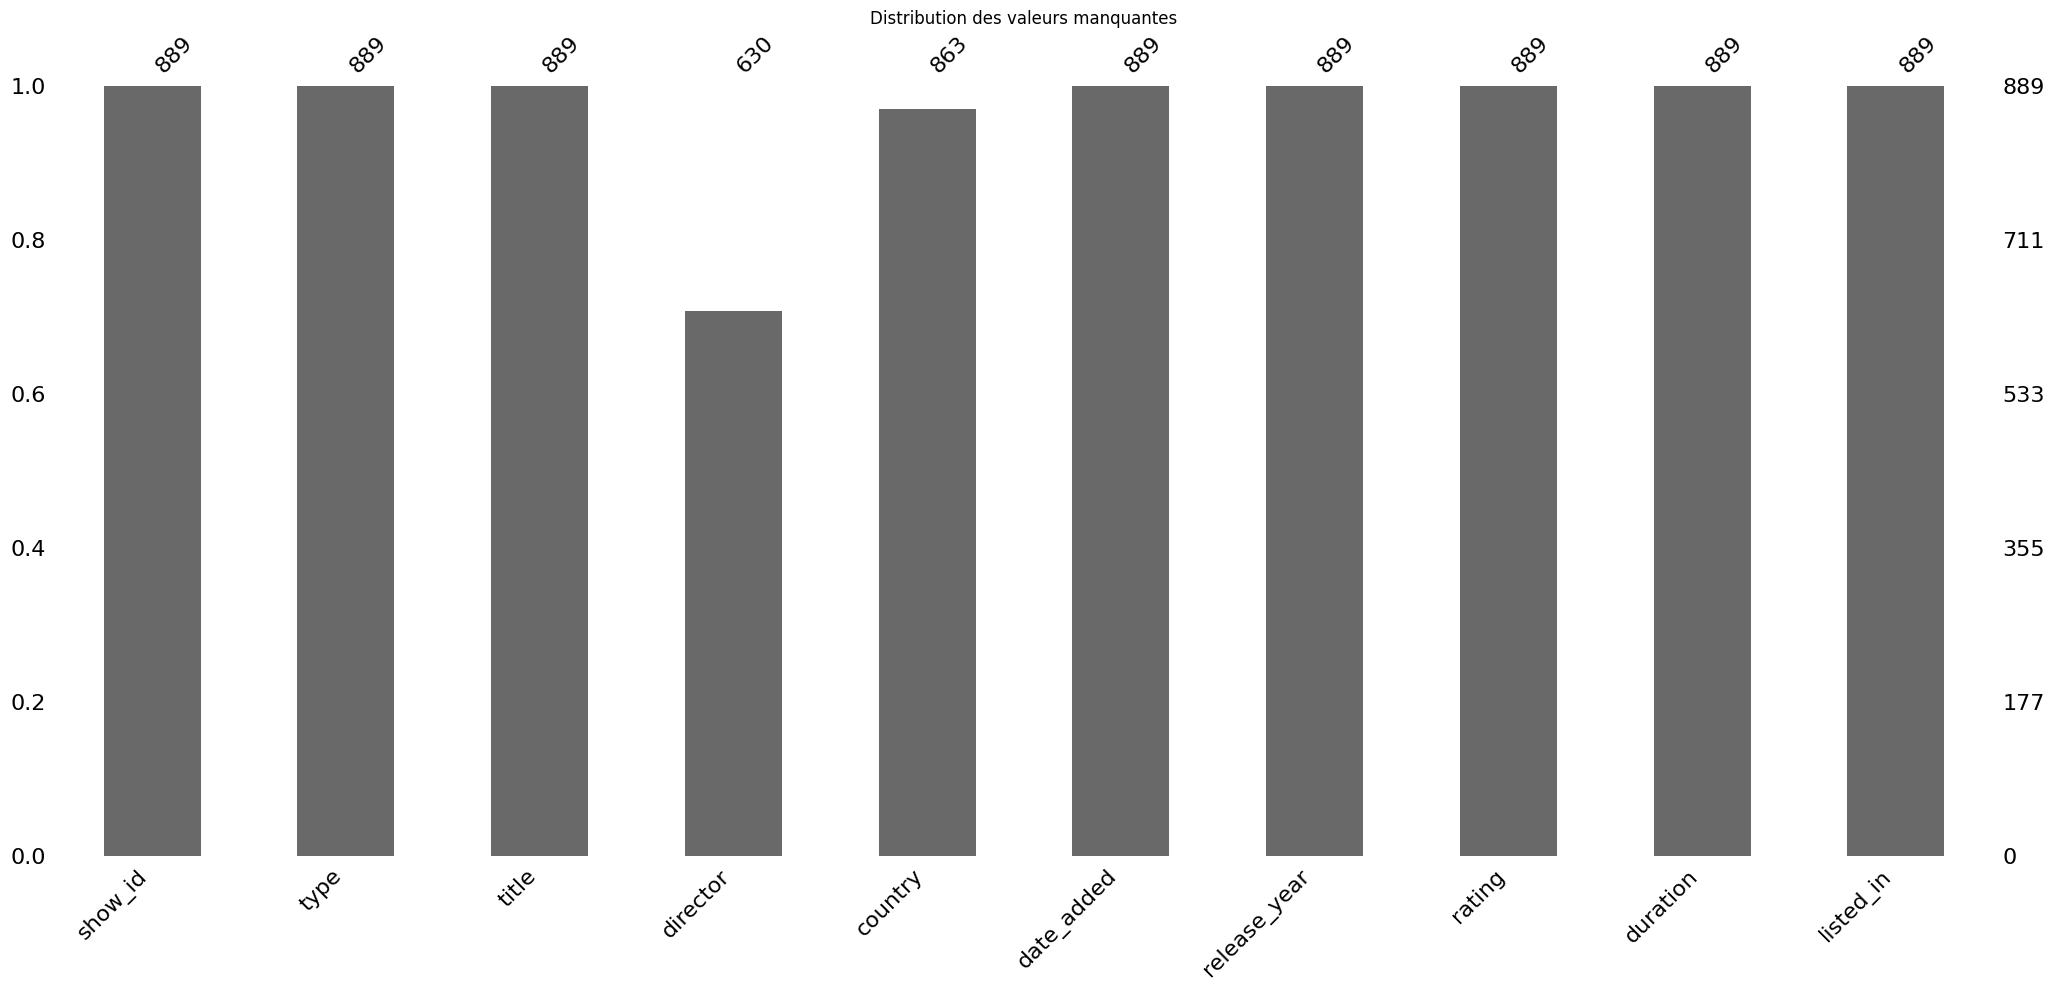

In [13]:
# Visualisation des valeurs manquantes sous forme de barres
msno.bar(df_echantillon)
plt.title("Distribution des valeurs manquantes")
plt.show()

### **Interprétation du graphique :**

*   Les colonnes avec les barres les plus courtes ont le plus de valeurs manquantes

*   Cela aide à identifier les colonnes nécessitant un nettoyage ou une attention particulière.

## **Étape 3 : Nettoyage et réinspection**

1. Appliquer un filtre pour supprimer les lignes manquantes dans certaines
colonnes clés  (par exemple director ou country) à l’aide de dropna()

In [17]:
# La note moyenne des films par studio
""""Les colonnes "director" et "country" sont cruciales pour notre analyse,
par exemple pour obtenir les performances par réalisateur ou la production par pays.
Des valeurs manquantes pourraient biaiser les résultats."""

df_filtered = df_films_cleaned.dropna(subset=["director", "country"])
df_filtered.show(5)

+-------+-------+--------------------+---------------+-------------+----------+------------+------+--------+--------------------+
|show_id|   type|               title|       director|      country|date_added|release_year|rating|duration|           listed_in|
+-------+-------+--------------------+---------------+-------------+----------+------------+------+--------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|United States| 9/25/2021|        2020| PG-13|  90 min|       Documentaries|
|     s3|TV Show|           Ganglands|Julien Leclercq|       France| 9/24/2021|        2021| TV-MA|1 Season|Crime TV Shows, I...|
|     s6|TV Show|       Midnight Mass|  Mike Flanagan|United States| 9/24/2021|        2021| TV-MA|1 Season|TV Dramas, TV Hor...|
|    s14|  Movie|Confessions of an...|  Bruno Garotti|       Brazil| 9/22/2021|        2021| TV-PG|  91 min|Children & Family...|
|     s8|  Movie|             Sankofa|   Haile Gerima|United States| 9/24/2021|        199

2. Générer un nouveau graphique Missingno sur le DataFrame ainsi
nettoyé pour comparer et constater la réduction des données
manquantes

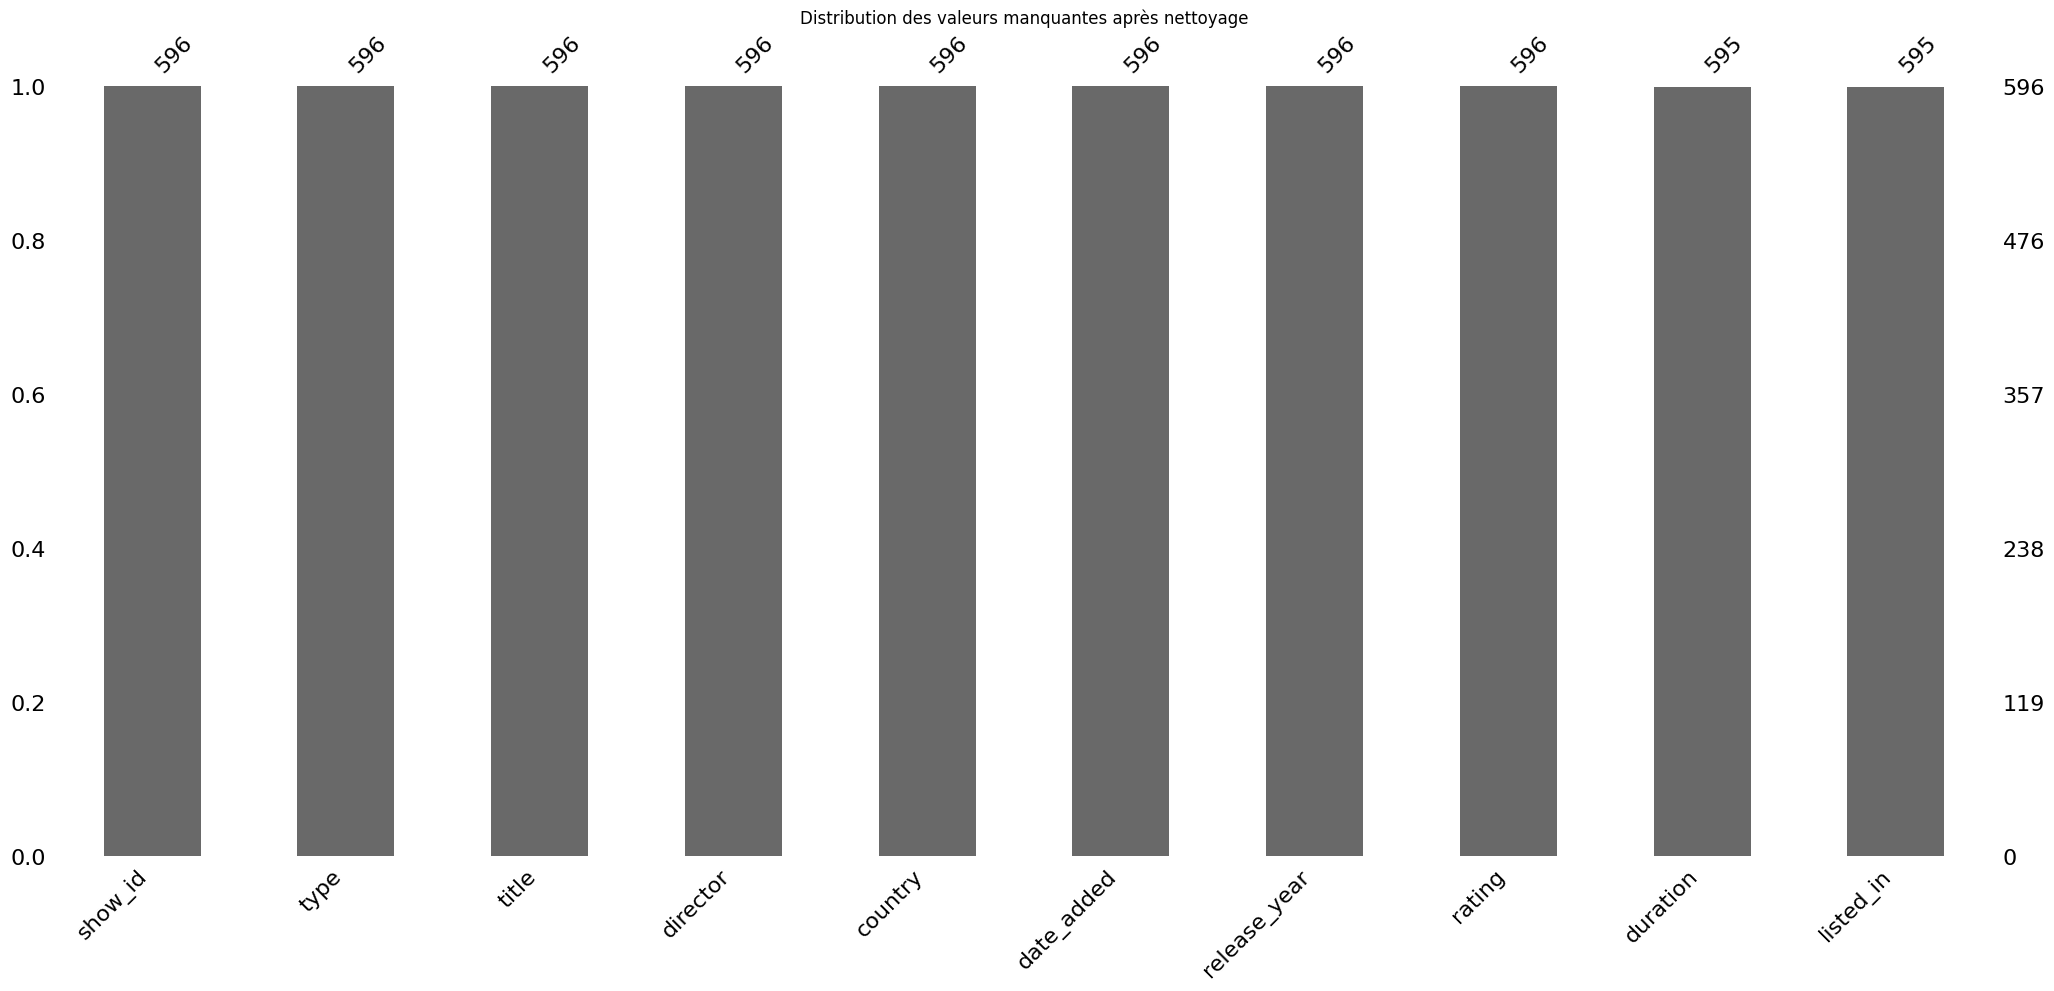

In [10]:
# Convertir en Pandas pour visualisation
df_filtered_sample = df_filtered.sample(fraction=0.1).toPandas()

# Visualisation après nettoyage
msno.bar(df_filtered_sample)
plt.title("Distribution des valeurs manquantes après nettoyage")
plt.show()

### **Analyse du résultat du nettoyage :**

*   D'apès le second graphique, les valeurs manquantes ont été significativement réduites après le nettoyage.
*   Les colonnes clés sont maintenant suffisamment complètes pour effectuer des analyses.

### **Étape 4 : Analyses complémentaires**

1.   Réfléchir à d’autres approches de traitement des données manquantes
(imputation, suppression ciblée, etc.)



*   **Imputation** : Ici cela correspond au fait de remplacer les valeurs manquantes par une estimation basée sur d'autres données (par exemple, la moyenne ou la médiane)




In [22]:
# Remplacement des valeurs manquantes dans la colonne duration par la moyenne
avg_duration = df_films_cleaned.select(avg(col("duration"))).collect()[0][0]
df_imputed = df_films_cleaned.fillna({"duration": avg_duration})

# Vérifier si la colonne duration contient encore des valeurs nulles
print("Valeurs nulles restantes dans 'duration' après imputation :")
df_imputed.filter(col("duration").isNull()).count()


Py4JJavaError: An error occurred while calling o200.fill.
: java.lang.NullPointerException
	at org.apache.spark.sql.DataFrameNaFunctions.$anonfun$fillMap$1(DataFrameNaFunctions.scala:418)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.DataFrameNaFunctions.fillMap(DataFrameNaFunctions.scala:407)
	at org.apache.spark.sql.DataFrameNaFunctions.fill(DataFrameNaFunctions.scala:232)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
output_path = "/content/drive/MyDrive/avg_rating_by_studio.csv"
df_avg_rating_studio.write.csv(output_path, header=True, mode="overwrite")
